In [432]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor

from torchvision import transforms, datasets
import torchvision.transforms.functional as fn
from PIL import Image


tensor([[[0.2980, 0.3098, 0.3176,  ..., 0.0392, 0.0471, 0.0549],
         [0.2980, 0.3059, 0.3020,  ..., 0.0471, 0.0510, 0.0549],
         [0.2980, 0.3137, 0.2784,  ..., 0.0863, 0.1020, 0.0941],
         ...,
         [0.4157, 0.4078, 0.3961,  ..., 0.4902, 0.5333, 0.6392],
         [0.4706, 0.4706, 0.4157,  ..., 0.5137, 0.6078, 0.5765],
         [0.4667, 0.4745, 0.4784,  ..., 0.5686, 0.5451, 0.6549]],

        [[0.2078, 0.2196, 0.2353,  ..., 0.0471, 0.0510, 0.0510],
         [0.2235, 0.2431, 0.2392,  ..., 0.0549, 0.0549, 0.0510],
         [0.2706, 0.2784, 0.2471,  ..., 0.0941, 0.1020, 0.0902],
         ...,
         [0.3882, 0.3843, 0.3725,  ..., 0.4667, 0.4980, 0.6039],
         [0.4431, 0.4471, 0.3922,  ..., 0.4902, 0.5843, 0.5529],
         [0.4392, 0.4471, 0.4549,  ..., 0.5490, 0.5255, 0.6314]],

        [[0.2392, 0.2510, 0.2549,  ..., 0.0275, 0.0314, 0.0353],
         [0.2314, 0.2431, 0.2392,  ..., 0.0353, 0.0353, 0.0353],
         [0.2314, 0.2431, 0.2039,  ..., 0.0824, 0.0941, 0.

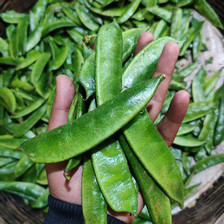

In [433]:
img = Image.open("data/Vegetable Images/test/Bean/0001.jpg")
img_tensor = fn.to_tensor(img)
print(img_tensor)
print(f"Mean: {img_tensor.mean()}\nStd: {img_tensor.std()}")
img


In [434]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [435]:
train_transform = transforms.Compose([transforms.RandomRotation(30),
                                      transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])])

In [436]:
dataset = datasets.ImageFolder('data/Vegetable Images/train', transform=train_transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)


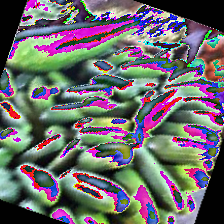

In [437]:
images, labels = next(iter(dataloader))
fn.to_pil_image(images[0])

In [438]:
print(labels)

tensor([ 9,  2, 10,  5,  5, 12,  4, 13,  0, 10, 14,  9,  9,  4,  6,  2, 11,  9,
        11,  2,  8, 12, 14,  4,  6,  4,  6,  0,  0, 11,  2, 14])


In [439]:
class VegetableClassifier(nn.Module):
    def __init__(self, out_size=15) -> None:
        super(VegetableClassifier, self).__init__()
        self.linear_out_size = out_size
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.network = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size= (7,7), stride=(2,2), padding=(3,3), bias=False), #maybe add bias?
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(64),
        )
        self.avg_maxpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.linear_classifier = nn.Linear(in_features=64, out_features=self.linear_out_size, bias=True)
        
    def forward(self, input):
        input = torch.unsqueeze(input, 0)
        input = self.network(input)
        input = self.avg_maxpool(input)
        input = torch.flatten(input, 1)
        return self.linear_classifier(input)
    
    def fit(self, num_epochs, loss_fn, optimizer, dataloader):
        for epoch in range(num_epochs):
            best_loss = 200000
            for xb, yb in dataloader:
                for i in range(len(xb)):
                    x = xb[i]
                    y = yb[i]
                    x = x.to(self.device)
                    y = y.to(self.device)

                    optimizer.zero_grad()
                    pred = self.forward(x)
                    loss = loss_fn(pred, y)
                    loss.backward()
                    optimizer.step()
                    
                    best_loss = loss if loss < best_loss else best_loss
            print(f"Epoch {epoch}: best_loss: {best_loss}")

                

In [440]:
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomRotation(30),
    #transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], 
                         [0.5, 0.5, 0.5])
])

In [441]:
dataset = datasets.ImageFolder('data/Vegetable Images/train', transform=train_transform) # temp changed to test
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [442]:
model = VegetableClassifier()
model.to(model.device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.99))
loss_fn = nn.CrossEntropyLoss()

In [443]:
images, labels = next(iter(dataloader))
images, labels = images.to(model.device), labels.to(model.device)
model.forward(images[0])

tensor([[-0.0572,  0.1184,  0.0519, -0.0975, -0.0830,  0.0763, -0.1240,  0.0050,
          0.1226, -0.0426, -0.0502,  0.0555,  0.0059,  0.1229,  0.0393]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [444]:
model.train()
model.fit(num_epochs=20, loss_fn=loss_fn, optimizer=optimizer, dataloader=dataloader)

14


ValueError: Expected input batch_size (1) to match target batch_size (0).